In [1]:
# give month as string number, 01, 02, 03, 05, 06 etc
# give "all" to get all months
# from 05, to 03. So don't use 04


#specific_month = "all"
specific_month = 'all'

# note: august, 08 has a small gap of missing data and messes up time related plots
# note: october, 10. has a big gap of missing data and messes up time related plots

In [2]:
# requires Sentiment Analysis to have transformed interactions table
# get plots for most negative polarity change, most positive; keywords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline
import sqlite3
from textblob import Word
from nltk.corpus import stopwords
import textblob as tb

import re
import json
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import numpy as np
from dbl_constants import airlines, lang_to_tag, tag_to_lang
import re
from datetime import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp
from IPython.core.display import display, HTML
from ast import literal_eval
import textblob as tb
from collections import Counter

def str_to_readable(s:str):
    return re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', s.replace('_',' '))
database_path = "temporary_database.sqlite3"
conn = sqlite3.connect(database_path)
cur = conn.cursor()

cur.execute("""PRAGMA table_info(TWEETS);""")
tweet_columns = tuple(t[1] for t in cur.fetchall())
cur.execute("""PRAGMA table_info(USERS);""")
user_columns = tuple(t[1] for t in cur.fetchall())
cur.execute("""PRAGMA table_info(INTERACTIONS);""")
interaction_columns = tuple(t[1] for t in cur.fetchall())
cur.execute("""PRAGMA table_info(EXPANDED_INTERACTIONS);""")
expanded_interaction_columns = tuple(t[1] for t in cur.fetchall())
cur.execute("""PRAGMA table_info(PLACES);""")
places_columns = tuple(t[1] for t in cur.fetchall())
cur.execute("""PRAGMA table_info(FULL_CONVERSATIONS);""")
full_conversations_columns = tuple(t[1] for t in cur.fetchall())
assert ("tb_polar" in tweet_columns), """This notebook requires textblob analysis on at least all english tweets. 
Run data_loading_w_sentiment. Or manually add columns using tb_enrich functions in data loading"""
print("data seems ok")



data seems ok


In [3]:
cur.execute("DROP VIEW IF EXISTS KLM_MONTH_EXPANDED_INTERACTIONS")
prompt: str
if specific_month == "all":
    prompt = """
    CREATE VIEW KLM_MONTH_EXPANDED_INTERACTIONS AS
    SELECT *
    FROM EXPANDED_INTERACTIONS
    WHERE airline == 56377143
    """
else:
    prompt = """
    CREATE VIEW KLM_MONTH_EXPANDED_INTERACTIONS AS
    SELECT *
    FROM EXPANDED_INTERACTIONS
    WHERE airline == 56377143
    AND strftime('%m', created_at_initial) == '@month'""".replace("@month", specific_month)
print(prompt)
cur.execute(prompt)



    CREATE VIEW KLM_MONTH_EXPANDED_INTERACTIONS AS
    SELECT *
    FROM EXPANDED_INTERACTIONS
    WHERE airline == 56377143
    


In [51]:
# get somewhat negative tweets which lower in polarity. And tweets with low polarity that remain low
# disregard any interactions that starts at higher than 0.3 polarity. Since the drop in polarity can simply be caused
# by a neutral tweet
cur.execute("""
SELECT * FROM KLM_MONTH_EXPANDED_INTERACTIONS
WHERE ((polarity_change < -0.1 AND tweet_polar < 0.3) OR (polarity_change < 0.1 AND tweet_polar < -0.2))
AND is_back_and_forth == 1""")
df_negative = pd.DataFrame(cur.fetchall(), columns=expanded_interaction_columns)
cur.execute("""
SELECT * FROM KLM_MONTH_EXPANDED_INTERACTIONS
WHERE  ((polarity_change >= -0.1 AND tweet_polar <0.3) AND (polarity_change >= 0.1 OR tweet_polar >= -0.2))
AND is_back_and_forth == 1""")
df_others = pd.DataFrame(cur.fetchall(), columns=expanded_interaction_columns)

In [52]:
df_negative["blob"] = df_negative["tweet_text"].apply(lambda x: tb.TextBlob(x.lower()))
# only get nouns
df_negative["words"] = df_negative["blob"].apply(lambda x: [w for (w, pos) in x.pos_tags if pos[0] == 'N'])
df_negative[["words"]]
# # tokenize paragraph into words.
# print(" Word Tokenize :\n", blob_object.words)

,words
0,"[thanks, airfrance, @, klm, delay, bud, i, con..."
1,"[team, skymiles, number, airport, trip, credit..."
2,"[klm, i, checks, flights, people, issues, chec..."
3,"[klm, hello, klm, i, flight, são, paulo, today..."
4,"[klm, @, flight, munich, answers, klm, airport..."
...,...
401,"[klm, flight, connection, strike, tomorrow, we..."
402,"[klm, @, airindiain, @, @, @, @, klm, advance,..."
403,"[@, klm, money, customer, service, dont, person]"
404,"[@, ’, point, dm, messaging, messages]"


In [53]:
df_others["blob"] = df_others["tweet_text"].apply(lambda x: tb.TextBlob(x.lower()))
# only get nouns
df_others["words"] = df_others["blob"].apply(lambda x: [w for (w, pos) in x.pos_tags if pos[0] == 'N'])
df_others[["words"]]

,words
0,"[thank, flight, hr, delay, phone, call, help, ..."
1,"[klm, thx, response, dm]"
2,"[klm, thanks, dm]"
3,"[klm, @, klm, mistake, flight, program, delta,..."
4,"[klm, thank, resolve, respond, request, bookin..."
...,...
1719,"[klm, i, flight, disruptions, mex, lufthansa, ..."
1720,"[klm, customer, care, guidelines, staff, lugga..."
1721,"[@, klm, flight, lounge, crap]"
1722,"[klm, i, mf811, xiamen, feb, flight, announcem..."


In [54]:
counter_unique = Counter()
counter = Counter()
for l in df_negative['words'].tolist():
    counter.update(set(l))
df_neg_wordcounts = pd.DataFrame.from_records(counter.most_common(), columns=['word','count'])
df_neg_wordcounts["perc"] = df_neg_wordcounts["count"]/len(df_negative['words'])
df_neg_wordcounts = df_neg_wordcounts.set_index("word")
df_neg_wordcounts

,count,perc
word,,
klm,321,0.790640
@,187,0.460591
i,185,0.455665
flight,112,0.275862
thanks,51,0.125616
...,...,...
poorservice,1,0.002463
iamstillwaitingforasolution,1,0.002463
chargingmetwice,1,0.002463


In [55]:
counter_unique = Counter()
counter = Counter()
for l in df_others['words'].tolist():
    counter.update(set(l))
df_others_wordcounts = pd.DataFrame.from_records(counter.most_common(), columns=['word','count'])
df_others_wordcounts["perc"] = df_others_wordcounts["count"]/len(df_others['words'])
df_others_wordcounts = df_others_wordcounts.set_index("word")
df_others_wordcounts

,count,perc
word,,
klm,1383,0.802204
@,731,0.424014
i,706,0.409513
flight,460,0.266821
’,161,0.093387
...,...,...
factor,1,0.000580
xiamen,1,0.000580
announcement,1,0.000580


In [59]:
combined_index = set(list(df_others_wordcounts.index) + list(df_neg_wordcounts.index))
df_neg_wordcounts = df_neg_wordcounts.reindex(combined_index, fill_value=0).sort_values("count", ascending=False)
df_neg_wordcounts

,count,perc
word,,
klm,321,0.790640
@,187,0.460591
i,185,0.455665
flight,112,0.275862
thanks,51,0.125616
...,...,...
wales,0,0.000000
zones,0,0.000000
cs,0,0.000000


In [67]:
df_others_wordcounts = df_others_wordcounts.reindex(combined_index, fill_value=0).sort_values("count", ascending=False)
df_others_wordcounts

,count,perc
word,,
klm,1383,0.802204
@,731,0.424014
i,706,0.409513
flight,460,0.266821
https,161,0.093387
...,...,...
atc,0,0.000000
forks,0,0.000000
🥴😡,0,0.000000


In [69]:
df_difference = df_neg_wordcounts - df_others_wordcounts
df_difference["perc_relative"] = (df_difference["perc"]/(df_others_wordcounts["perc"]))
df_wordcloud = df_difference[df_difference["perc_relative"] < 100].sort_values("perc_relative", ascending=False).head(50)
df_wordcloud

,count,perc,perc_relative
word,,,
behaviour,4,0.011735,20.231527
reps,4,0.011735,20.231527
rude,3,0.009272,15.985222
level,3,0.009272,15.985222
lombardy,3,0.009272,15.985222
veneto,3,0.009272,15.985222
arrangements,2,0.006809,11.738916
🛫,2,0.006809,11.738916
sure,2,0.006809,11.738916


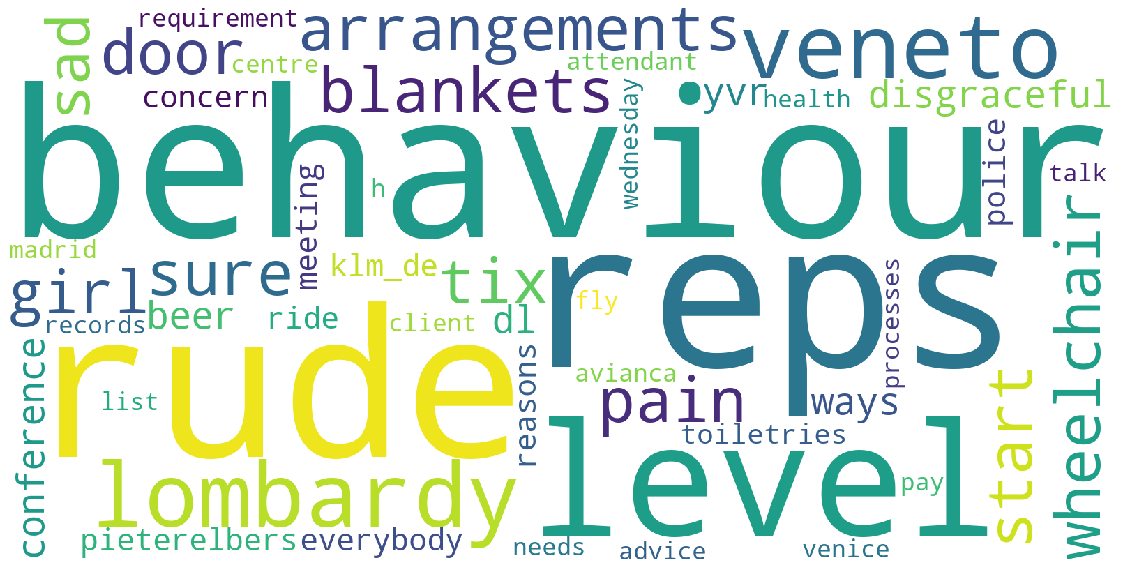

In [72]:
plt.figure(figsize=(20,20))
wcp = WordCloud(max_words=1000, width=1600, height=800, collocations=False,
               background_color = 'white').generate(" ".join(df_wordcloud.index))
plt.axis("off")
plt.imshow(wcp)